We show how to use iGNN on the simiulated three-moon data (cf. Figure 3)

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install imageio==2.4.1
!pip install pickle5
!pip install -q mediapy
!pip install GPUtil
!pip install git+https://github.com/VLL-HD/FrEIA.git

In [2]:
import pandas as pd
import torch.nn as nn
import mediapy as media
import IPython.display as display
from IPython.display import clear_output
import ipywidgets as widgets
import visualize_new_code as viz
import L3net as l3
import networkx as nx
import numpy as np
import torch
import matplotlib.pyplot as plt
import Nets_new_code_efficient as nets
import utils_training_new_code as utils
import utils_data_new_code as utils_data
import importlib as ipb
import itertools
import torch_geometric as pyg
from PIL import Image
import sys
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Helper functions

In [3]:
def get_training_input(name, version, edge_index, X_train, Y_train, X_test=None, Y_test=None):
    edge_index = None
    A_ = None
    use_graph = False
    mean_0 = X_train[Y_train == 0].mean(axis=0).to(device)
    mean_1 = X_train[Y_train == 1].mean(axis=0).to(device)
    mean_2 = X_train[Y_train == 2].mean(axis=0).to(device)
    mult1, mult2, mult3 = 1, 1, 1
    fix_W_g_b_g = True
    lr0 = 1e-3
    optim_classify = False
    scheduler = None
    mu, gamma = 1, 1
    resume_checkpoint = True
    data_name = f'three_moon_{version}'
    X_train, Y_train = X_train.to(device), Y_train.to(device)
    num_viz, num_to_plot = 1, 100
    edge_weight = None
    torch.manual_seed(1103)
    model_graph = nets.InvResNet(C, output_dim, nblocks=nblocks,
                                 model_args=model_args, graph=use_graph, version=version, A_=A_).to(device)
    gen_dim = min(2, C)
    gen_net = nets.SmallGenNet(Y_dim, gen_dim).to(device)
    with torch.no_grad():
        gen_net.fc.weight = torch.nn.Parameter(
            torch.transpose(torch.vstack([mult1*mean_0, mult2*mean_1, mult3*mean_2]), 0, 1).to(device))
        gen_net.fc.bias = torch.nn.Parameter(
            torch.zeros(gen_dim).to(device))
    if fix_W_g_b_g:
        for param in gen_net.parameters():
            param.requires_grad = False
    optimizer = torch.optim.Adam(
        model_graph.parameters(), lr=lr0, weight_decay=5e-4)
    optimizer_gen_net = torch.optim.Adam(
        gen_net.parameters(), lr=lr0, weight_decay=0.5)
    models = [model_graph, gen_net]
    mod_args = [model_args[1], nblocks]
    train_args = [optimizer, optimizer_gen_net, optim_classify, mu, gamma,
                  epochs, scheduler, resume_checkpoint]
    data_args = [edge_index, edge_weight,
                 batch_size, data_name, num_viz, num_to_plot]
    return [models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test]

In [4]:
def load_model(foldername = 'two_moon_four_FC', data_name='two_moon', net_type = 'three_FC'):
    ##### Load model
    V, C, batch_size, epochs, F_out = 1, 2, 100, 30, 1
    # NOTE, the first term is the reduce factor of initial weights of model
    model_args = [0.9, 64, 3]
    if 'two' in data_name:
        N = 20000
        output_dim, Y_dim = 1, 2
        X_np, y_np, X_train, Y_train = utils_data.gen_two_moon_data(N, data_name)
        data_type = 'simulation_non_graph'
    if 'three' in data_name:
        N = 45000 # 15K per node
        # N_per_moon = int(N/3)
        N_per_small_moon = 10000
        N_per_large_moon = 25000
        output_dim, Y_dim = 3, 3
        X_np, y_np, X_train, Y_train = utils_data.make_many_moons(N_per_small_moon,N_per_small_moon,N_per_large_moon)
        data_type = 'simulation_three_moon'
    X_train, Y_train = X_train.reshape(N, V, C), Y_train.reshape(N, V)
    torch.manual_seed(1103)
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        data_type, net_type, edge_index, X_train, Y_train)
    data_args[3] = foldername
    train_args[-1] = True  # If resume_training
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.cpu_load = False
    simulation_trainer.load_losses = False # If true, do not load saved losses
    simulation_trainer.load_from_checkpoint()  # Load previous models from file
    simulation_trainer.get_H_cond_Y()  # Get H|Y
    simulation_trainer.viz = True  # If False, report transport cost
    simulation_trainer.final_viz = True
    return simulation_trainer


def get_two_moon_trajectory(self, from_X_to_H=False, three_moon = False):
    self.from_X_to_H = from_X_to_H
    blocks = self.model.blocks if self.from_X_to_H else reversed(
        self.model.blocks)
    N = self.X_train.shape[0]
    if self.from_X_to_H:
        input = self.X_train.view(N, -1)
    else:  
        if three_moon:
            _, counts = torch.unique(simulation_trainer.Y_train,return_counts=True)
            H0 = self.base_dist0.rsample(sample_shape=(counts[0].item(),))
            H1 = self.base_dist1.rsample(sample_shape=(counts[1].item(),))
            H2 = self.base_dist2.rsample(sample_shape=(counts[2].item(),))
            input = torch.vstack([H0, H1, H2]).to(device)
        else:
            N_sub = int(N/2)
            H0 = self.base_dist0.rsample(sample_shape=(N_sub,))
            H1 = self.base_dist1.rsample(sample_shape=(N_sub,))
            input = torch.vstack([H0, H1]).to(device)
    input_ls = [input]
    with torch.no_grad():
        for block in blocks:
            block.logdet = False
            if self.from_X_to_H:
                # Here H_full is actually X
                input, Fx, _ = block(input)

                transport_cost = (torch.linalg.norm(Fx.flatten(start_dim=1),
                                                    dim=1)**2/2).sum().item()/N
                self.transport_cost_XtoH_ls.append(transport_cost)
            else:
                input1 = block.inverse(input)
                transport_cost = (torch.linalg.norm(
                    (input1-input).flatten(start_dim=1), dim=1)**2/2).sum().item()/N
                self.transport_cost_HtoX_ls.append(transport_cost)
                input = input1
            input_ls.append(input)
    input_all = torch.stack(input_ls).cpu().detach().numpy()
    return input_all

## Training

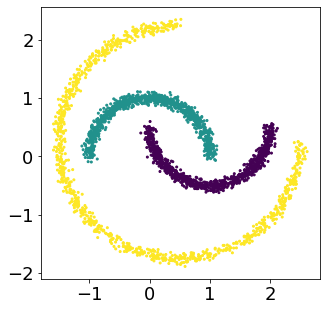

In [8]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    V, C, batch_size, epochs, F_out = 1, 2, 150, 500, 1
    output_dim, Y_dim, nblocks = 3, 3, 50
    # NOTE, the first term is the reduce factor of initial weights of model
    model_args = [0.9, 64, 3] 
    N = 3000
    N_per_moon = int(N/Y_dim)
    X_np, y_np, X_train, Y_train = utils_data.make_many_moons(N_per_moon,N_per_moon,N_per_moon)
    X_train, Y_train = X_train.reshape(N, V, C), Y_train.reshape(N, V)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(X_np[:, 0], X_np[:, 1], c=y_np, s=4)

In [ ]:
for _ in ['Training_IRresNet']:
    torch.manual_seed(1103)
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'simulation_three_moon', 'four_FC', edge_index, X_train, Y_train)
    data_args[-1] = 500 # Num to plot
    train_args[-1] = False
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.X_dist = 'three_moon'
    # From original two moon weights
    weights = torch.tensor([[1.5,-1,3], [1.5,-1,-1]], device=device)
    with torch.no_grad():
        simulation_trainer.gen_net.fc.weight.data = weights.data
        simulation_trainer.gen_net.fc.bias.data = torch.zeros(2).to(device)
    # Train the "beads"
    for p in simulation_trainer.gen_net.fc.parameters():
        p.requires_grad = True
    simulation_trainer.gamma = 0.5*nblocks
    simulation_trainer.stop_criterion = 1e-10
    simulation_trainer.optimizer.param_groups[0]['lr'] = 1e-3
    simulation_trainer.optim_classify = True
    simulation_trainer.r_mult = 1  # Train means, as repulsion loss
    simulation_trainer.all_together()

## Visualization

In [ ]:
input_all_ls = []
foldername = 'three_moon_four_FC'
nblocks = 48
simulation_trainer = load_model(foldername, data_name='three_moon', net_type = 'four_FC')

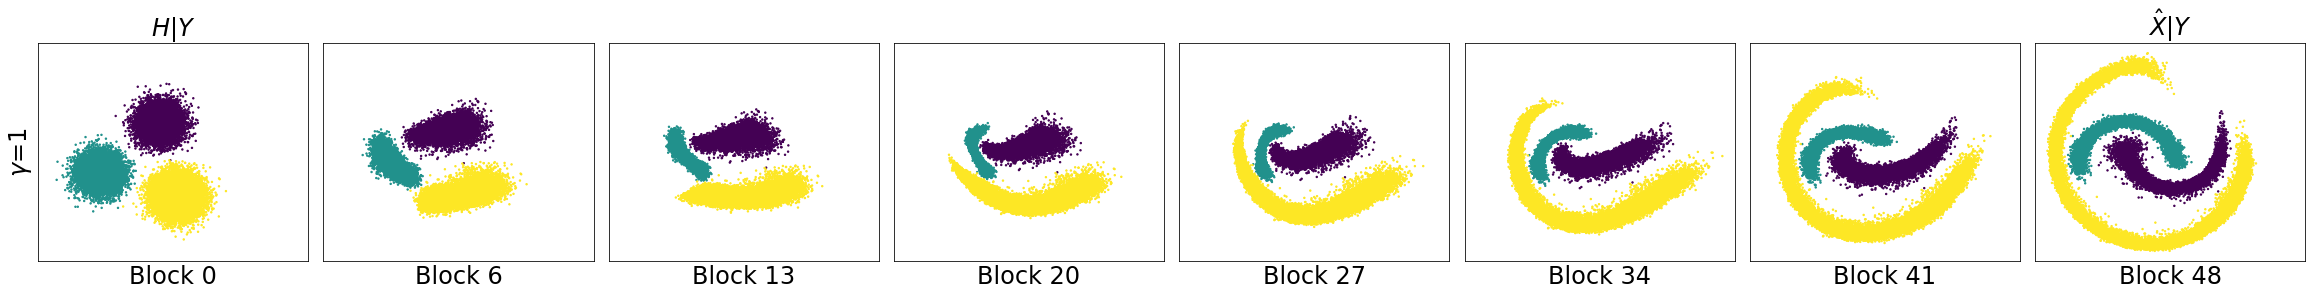

In [ ]:
###### Get trajectory and plot ######
from_X_to_H = False
input_all_gam = get_two_moon_trajectory(simulation_trainer, from_X_to_H=from_X_to_H, three_moon = True)
input_all_ls.append(input_all_gam)
_, counts = torch.unique(simulation_trainer.Y_train,return_counts=True)
Ys = np.repeat([0,1,2],counts.cpu().numpy())
fig = viz.plot_img_over_trajectory(input_all_ls, gamma_ls = [1], num_per_row = 8, from_X_to_H=False, Ys = Ys)
fig.savefig(f'{simulation_trainer.path}/Trajectory_over_gamma_entangle.png',dpi=100, bbox_inches='tight', pad_inches=0)
fig_density = viz.plot_img_over_trajectory(input_all_ls, gamma_ls = [1], num_per_row = 8, from_X_to_H=False)
fig_density.savefig(f'{simulation_trainer.path}/Trajectory_over_gamma_entangle_density.png',dpi=100, bbox_inches='tight', pad_inches=0)

Quantiles: [60 65 70 75 80 85 90] 
 Log_prob: [-1.10000002 -0.69999999 -0.40000001 -0.2         0.          0.1
  0.30000001]


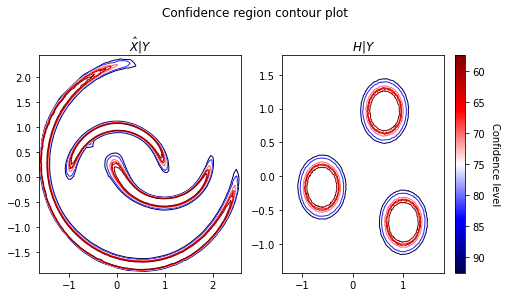

In [ ]:
self = simulation_trainer
self.N0 = 3000
self.N1 = 3000
self.N2 = 3000

# Get confidence region of X
H0 = self.base_dist0.rsample(sample_shape=(self.N0,))
H0_log_prob = self.base_dist0.log_prob(H0)
H1 = self.base_dist1.rsample(sample_shape=(self.N1,))
H1_log_prob = self.base_dist1.log_prob(H1)
H2 = self.base_dist2.rsample(sample_shape=(self.N2,))
H2_log_prob = self.base_dist2.log_prob(H2)
H_full = torch.vstack([H0, H1, H2]).to(device)
H_full_log_prob = torch.hstack(
    [H0_log_prob, H1_log_prob, H2_log_prob]).to(device)
H_full_log_prob = torch.round(H_full_log_prob, decimals=1)
H_full = H_full.reshape(H_full.shape[0], 1, H_full.shape[1])
X_pred = self.model.inverse(H_full, self.edge_index, maxIter=50).cpu()
keep = X_pred.norm(dim=(1,2)) <= 10
X_pred = X_pred[keep]
H_full = H_full[keep]
X_pred = X_pred.view(X_pred.shape[0], -1)
H_full = H_full.view(H_full.shape[0], -1)
H_full_log_prob = H_full_log_prob[keep]
fig_log_prob = viz.plot_contour_over_region(X_pred, H_full, H_full_log_prob, type='log_prob', dataname = 'three_moon', savefig=True)